In [1]:
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append("LogisticCircuit")
sys.path.append("pypsdd")
sys.path.append('..')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

import argparse
import pickle

try:
    from time import perf_counter
except:
    from time import time
    perf_counter = time

import datetime
import os
import logging
import pickle
import gzip
import json

import numpy as np

from utils_missing import run_missing_exp, plot_results_paper, do_other_impute

from LogisticCircuit.structure.Vtree import generate_random_vtree
from LogisticCircuit.algo.LogisticCircuit import learn_logistic_circuit
from LogisticCircuit.util.DataSet import DataSet
from LogisticCircuit.algo.RegressionCircuit import learn_regression_circuit, RegressionCircuit

import psdd_io
from manager import PSddManager
from algo.LogisticCircuit import LogisticCircuit
from structure.Vtree import Vtree as LC_Vtree
from vtree import Vtree as PSDD_Vtree

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score

c:\users\pashak\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\pashak\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def merge_plot(dataset, out_path, regression, exp_id, result_path = None, do_second_other = False, second_other_keys=["mean"], show =  ["circuit", "mean", "median", "mice", "mpe"], do_gzip = False, YLABEL = ""):
    
    dataset_name = os.path.basename(dataset).replace('.pklz', '')
    with gzip.open(dataset, 'rb') as f:
        data_splits = pickle.load(f)
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = data_splits

    if not regression:
        y_train = y_train.astype(np.int8)
        y_valid = y_valid.astype(np.int8)
        y_test = y_test.astype(np.int8)
        
    if result_path is None:
        result_path = os.path.join(out_path, f'{dataset_name}_{exp_id}_missing_result.pickle')
    
    result_path_other = os.path.join(out_path, f'{dataset_name}_{exp_id}_missing_other_result.pickle')
    
    result_path_other_second = os.path.join(out_path, f'{dataset_name}_{exp_id}_missing_other_result_temp.pickle')
    
    
    
    with open(result_path, "rb") as infile:
        result = pickle.load(infile)

    if do_gzip:
        result_path_other += "z"
        with gzip.open(result_path_other, "rb") as infile:
            result_other = pickle.load(infile)
            
        if do_second_other:
            result_path_other_second += "z"
            with gzip.open(result_path_other_second, "rb") as infile:
                result_other_second = pickle.load(infile)
            
    else:
        with open(result_path_other, "rb") as infile:
            result_other = pickle.load(infile)
        if do_second_other:
            with open(result_path_other_second, "rb") as infile:
                result_other_second = pickle.load(infile)
        
    sqrt_mse = lambda x,y: np.sqrt(mean_squared_error(x,y))
        
    
#     to_del = []
    
#     for prd in result["predictions"]:
#         a,b,c = prd
#         if a == "mean":
#             to_del.append(prd)
    
#     for dd in to_del:
#         del result["predictions"][dd]
    
    for prd in result_other["other_predictions"]:
        result["predictions"][prd] = result_other["other_predictions"][prd]
        
    if do_second_other:
        for prd in result_other_second["other_predictions"]:
            a,b,c = prd
            if a in second_other_keys:
                result["predictions"][prd] = result_other_second["other_predictions"][prd]

    
    print(result["k"])
    
#     for prd in result["predictions"]:
#         a,b,c = prd
#         if a == "mean":
#             print(b,c, sqrt_mse(result["predictions"][prd],result["y_true"]))
    
    plot_path_sqrtmse = os.path.join(out_path, f'{dataset_name}_{exp_id}_sqrtmse_plot_merged.pdf')
    plot_setting_sqrtmse = {
                "show":  show,
                "saveAs": plot_path_sqrtmse,
                "function": sqrt_mse,
                "Ylabel": YLABEL,
                "title": dataset_name.capitalize(),
                "size": (8,7)
                #'subset': np.array([True if i < 5 else False for i in range(len(K))]),
    }
    print(plot_path_sqrtmse)
    return plot_results_paper(result, yTrue=result["y_true"], setting=plot_setting_sqrtmse)

In [3]:
dataset = "data/abalone/abalone.pklz"
out_path = "exp/new-reg-circuit-grid/abalone/abalone_20190520-182501/best/"
regression = True
exp_id = "try-I"

[ 0  7 14 21 28 36 43 50 57 64 72]
exp/new-reg-circuit-grid/abalone/abalone_20190520-182501/best/abalone_try-I_sqrtmse_plot_merged.pdf
{'mpe', 'median', 'mean', 'circuit', 'mice'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

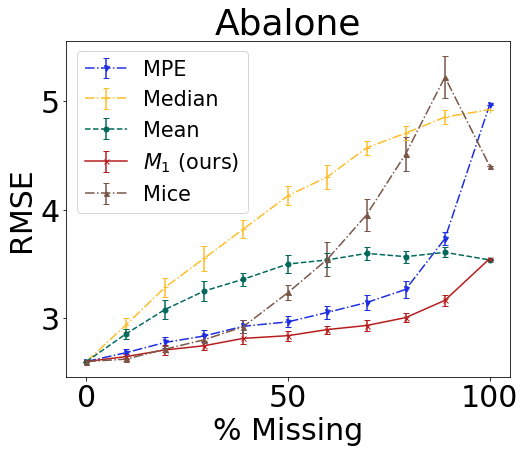

In [4]:
merge_plot(dataset, out_path, regression, exp_id, show =  ["circuit", "median", "mice", "mpe", "mean"], YLABEL = "RMSE", do_gzip=True)

In [5]:
dataset2 = "data/insurance/insurance.pklz"
out_path2 = "exp/new-reg-circuit-grid/insurance/insurance_20190520-184809/best"
regression2 = True
exp_id2 = "try-I"

[ 0  3  7 10 14 18 21 25 28 32 36]
exp/new-reg-circuit-grid/insurance/insurance_20190520-184809/best\insurance_try-I_sqrtmse_plot_merged.pdf
{'mpe', 'median', 'mean', 'circuit', 'mice'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

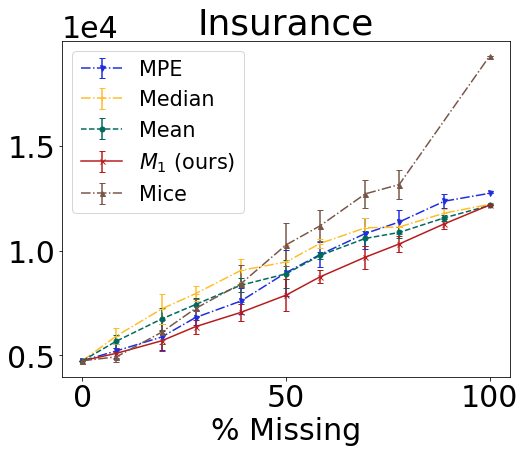

In [6]:
merge_plot(dataset2, out_path2, regression2, exp_id2, show = ["circuit", "mean", "median", "mice", "mpe"])

In [7]:
dataset3 = "data/boston/boston.pklz"
out_path3 = "exp/new-reg-circuit-grid/boston/boston_20190520-180922/best"
regression3 = True
exp_id3 = "try-I"

[  0  19  38  57  76  96 115 134 153 172 192]
exp/new-reg-circuit-grid/boston/boston_20190520-180922/best\boston_try-I_sqrtmse_plot_merged.pdf
{'mpe', 'median', 'mean', 'circuit', 'mice'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

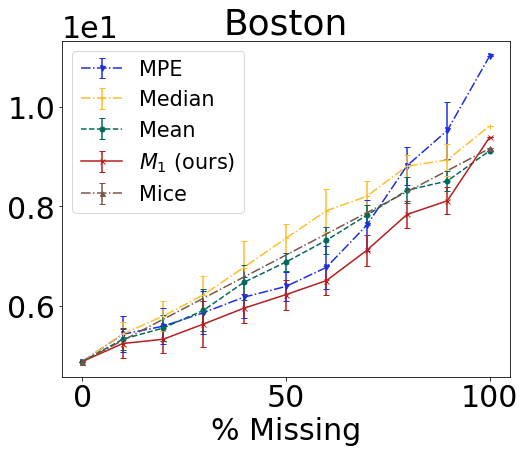

In [8]:
merge_plot(dataset3, out_path3, regression3, exp_id3,  show = ["circuit", "mean", "median", "mpe", "mice"], do_gzip = True)

[ 0  8 17 26 35 44 52 61 70 79 88]
exp/new-reg-circuit-grid/kinematics/kinematics_20190520-234527/best\kinematics_try-I_sqrtmse_plot_merged.pdf
{'mpe', 'median', 'mean', 'circuit', 'mice'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

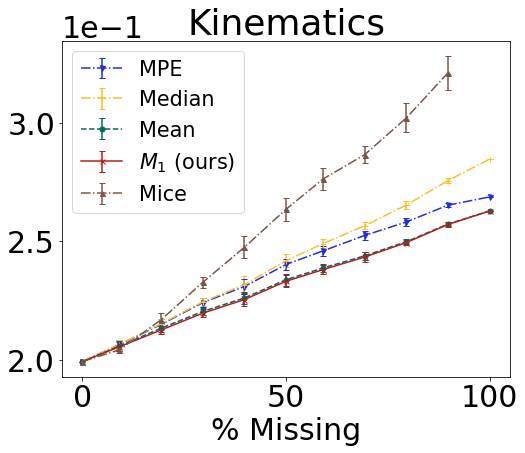

In [9]:
dataset_kin = "data/kinematics/kinematics.pklz"
out_path_kin = "exp/new-reg-circuit-grid/kinematics/kinematics_20190520-234527/best"
regression_kin = True
exp_id_kin = "try-I"
show_kin = ["circuit", "median", "mpe", "mice", "mean"]
merge_plot(dataset_kin, out_path_kin, regression_kin, exp_id_kin, do_second_other = True, second_other_keys = ["mean"],  show = show_kin, do_gzip = False)

[  0  18  36  54  72  91 109 127 145 163 182]
exp/new-reg-circuit-grid/elevators/elevators_20190520-185859/best\elevators_try-I_sqrtmse_plot_merged.pdf
{'mpe', 'median', 'mean', 'circuit', 'mice'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

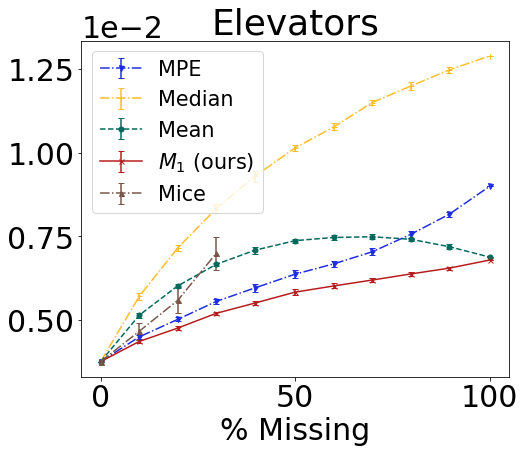

In [10]:
dataset_elev = "data/elevators/elevators.pklz"
out_path_elev = "exp/new-reg-circuit-grid/elevators/elevators_20190520-185859/best"
regression_evel = True
exp_id_evel = "try-I"
show_elev = ["circuit", "median", "mpe", "mice", "mean"]
merge_plot(dataset_elev, out_path_elev, regression_evel, exp_id_evel, do_second_other = True, second_other_keys = ["mean", "mpe"], show = show_elev, do_gzip = False)

[  0  20  40  60  81 101 121 142 162 182 203]
exp/new-reg-circuit-grid/compact/compact_20190521-002416/best\compact_try-I_sqrtmse_plot_merged.pdf
{'circuit', 'mpe', 'mice', 'median'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

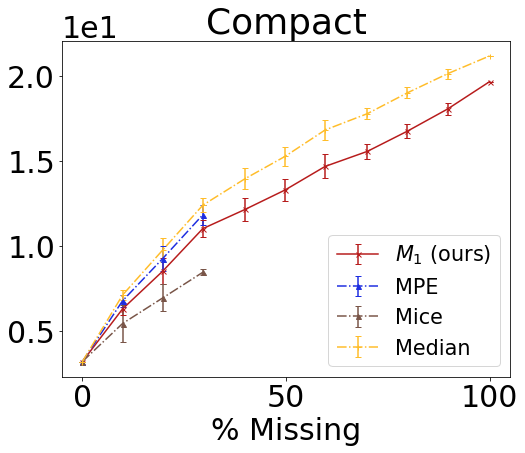

In [11]:
dataset4 = "data/compact/compact.pklz"
out_path4 = "exp/new-reg-circuit-grid/compact/compact_20190521-002416/best"
regression4 = True
exp_id4 = "try-I"
merge_plot(dataset4, out_path4, regression4, exp_id4,  show = ["circuit", "median", "mpe", "mice"], do_gzip = False)

In [ ]:
dataset_air = "data/delta-ailerons/delta-ailerons.pklz"
out_path_air = "exp/new-reg-circuit-grid/delta-ailerons/delta-ailerons_20190520-190320/best"
regression_air = True
exp_id_air = "try-I"
#result_path_air = "exp/new-reg-circuit-grid/delta-ailerons/delta-ailerons_20190520-190320/best/delta-ailerons_try-I_missing_result.pickle"
show_air = ["circuit", "median", "mpe", "mice", "mean"]
merge_plot(dataset_air, out_path_air, regression_air, exp_id_air, 
           result_path = result_path_air,
           do_second_other = True, second_other_keys = ["mean"], show = show_air, do_gzip = True)

In [44]:
def merge_mnist_stuff(dataset, out_path, regression, exp_id, K, repeat, show = ["circuit", "mean", "median"], 
                      do_gzip = False, do_other_result=False,
                     YLABEL="Accuracy"):
    
    dataset_name = os.path.basename(dataset).replace('.pklz', '')
    with gzip.open(dataset, 'rb') as f:
        data_splits = pickle.load(f)
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = data_splits

    if not regression:
        y_train = y_train.astype(np.int8)
        y_valid = y_valid.astype(np.int8)
        y_test = y_test.astype(np.int8)

    if do_other_result:
        result_path_other = os.path.join(out_path, f'{dataset_name}_{exp_id}_missing_other_result.pickle')
        if do_gzip:
            result_path_other += "z"
            with gzip.open(result_path_other, "rb") as infile:
                result_other = pickle.load(infile)
        else:
            with open(result_path_other, "rb") as infile:
                result_other = pickle.load(infile)

    result = {}
    first = True
    
    for ki, k in enumerate(K):
        for r in range(repeat):
            batch_path = f"exp/{dataset_name}-final/{dataset_name}_{exp_id}-{k}-{r}_missing_result.picklez"
        
            #print(batch_path)
            with gzip.open(batch_path, "rb") as infile:
                cur_result = pickle.load(infile)  
            
            if first:
                result = cur_result
                first = False
            else:
                for prd in cur_result["predictions"]:
                    name, A,B = prd
                    result["predictions"][(name, ki, r)] = cur_result["predictions"][prd]
                    
                #for prd in cur_result["missing_all"]:
                #print("here", ki, r)
                result["missing_all"][(ki, r)] = cur_result["missing_all"][(0,0)]
        
    

    if do_other_result:
        for prd in result_other["other_predictions"]:
            result["predictions"][prd] = result_other["other_predictions"][prd]
            
            #print(result_other["other_predictions"][prd])
    
    #print(result["predictions"][("mean", 0 ,2)].shape)
    result["k"] = K * (0.01 * 28*28)
    result["repeat"] = repeat
    
    ALL_MERGED = f"exp/{dataset_name}-final/{dataset_name}_{exp_id}_missing_result.pickle"
    with open(ALL_MERGED, "wb") as fout:
        pickle.dump(result, fout)
    
    plot_path = os.path.join(out_path, f'{dataset_name}_{exp_id}_all_plot_merged.pdf')
    plot_setting_cur = {
                "show":  show,
                "saveAs": plot_path,
                "function": accuracy_score,
                "Ylabel": YLABEL,
                "title": dataset_name.upper(),
                "regression": False,
                "mult": 100,
    }
    print(plot_path)
    return plot_results_paper(result, yTrue=result["y_true"], setting=plot_setting_cur)            
            
    

exp/mnist-final/mnist_trial-III_all_plot_merged.pdf
{'circuit_1', 'mpe', 'mean', 'median'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

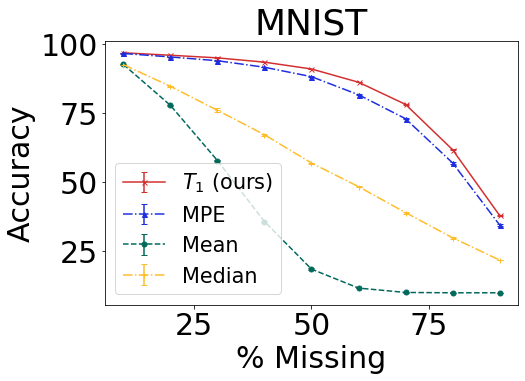

In [45]:
dataset_100 = "data/mnist/mnist.pklz"
out_path_100 = "exp/mnist-final/"
regression_100 = False
exp_id_100 = "trial-III"
K_100 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
Repeat_100 = 3
show_100 = ["circuit_1", "median", "mean", "mpe"] # "circuit_2", "circuit_3"

merge_mnist_stuff(dataset_100, out_path_100, regression_100, exp_id_100, K_100, 
                  Repeat_100, 
                  do_other_result=True,
                  do_gzip=True,
                  show = show_100)

exp/fmnist-final/fmnist_trial-III_all_plot_merged.pdf
{'circuit_1', 'mpe', 'mean', 'median'}


<module 'matplotlib.pyplot' from 'c:\\users\\pashak\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

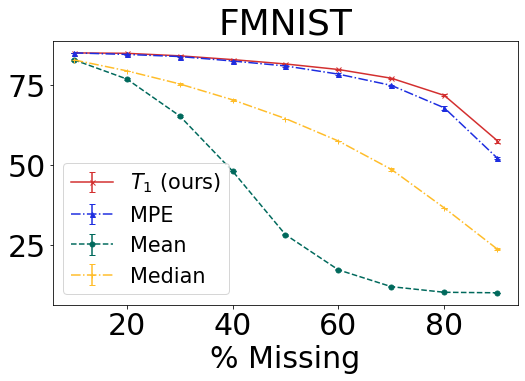

In [47]:
dataset_101 = "data/fmnist/fmnist.pklz"
out_path_101 = "exp/fmnist-final/"
regression_101 = False
exp_id_101 = "trial-III"
K_101 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
Repeat_101 = 3
show_101 = ["mean", "median", "circuit_1", "mpe"] # "circuit_2", "circuit_3", "circuit_0", "circuit_1", "median",
merge_mnist_stuff(dataset_101, out_path_101, regression_101, exp_id_101, K_101, Repeat_101, show = show_101, 
                  do_gzip = True,
                  do_other_result=True,
                  YLABEL=""
                 )

In [17]:
result_path_other_fashion = "exp/fmnist-final/fmnist_trial-III_missing_other_result.picklez"

result_path_fashion = "exp/fmnist-final/fmnist_trial-III_missing_result.pickle"
result_path_mnist = "exp/mnist-final/mnist_trial-III_missing_result.pickle"

with gzip.open(result_path_other_fashion, "rb") as infile:
    result_other_fashion = pickle.load(infile)
    
with open(result_path_fashion, "rb") as infile:
    result_fashion = pickle.load(infile)
with open(result_path_mnist, "rb") as infile:
    result_mnist = pickle.load(infile)

In [18]:
accuracy_score(result_other_fashion["other_predictions"][("mean", 0, 1)], result_fashion["y_true"])

0.831